## Survival Analysis
- A popular topic in Applied Data Science is called survival analysis, a.k.a churn analysis. A survival analysis is the analysis of a special type of outcome variable i.e., the time until an event occurs. The event can be death, subscription cancellation, etc. 

- The survival curve, or survival function, is defined as $S(t) = P(T>t)$, where $T$ is the actual survival time.
- $S(t)$ indicates the probability that the subject survives at least up to time $t$. 
- This notebook employs the BrainCancer datasets [1] as an example to summaries some basic concepts of survival analysis. Please refer to [2] for more details about those concepts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [2]:
df = pd.read_csv('brain_cancer.csv')
df['_id'] = df.index

### Kaplan-Meier Survival Curve

#### Manual Calculation of Kaplan-Meier Survival Curve

Let $d_1 < d_2 < · · · < d_k$ denote the $k$ unique death times among the noncensored subjects, by Law of Total Probability,
$$ P(T>d_k) = P(T>d_k|T>d_{k-1})P(T>d_{k-1}) + P(T>d_k|T \leq d_{k-1})P(T \leq d_{k-1}) $$

Since $P(T>d_k|T \leq d_{k-1})=0$ i.e. it is impossible for a subject to survive up to $d_k$ if it doesn't survive until $d_{k-1}$, we can conclude that:
$$ S(d_k) = P(T>d_k) = P(T>d_k|T>d_{k-1})P(T>d_{k-1}) $$

Solving this recursively, we get
$$ S(d_k) = P(T>d_k|T>d_{k-1})P(T>d_{k-1}) \times ... \times P(T>d_2|T>d_1)P(T>d_1) $$

A natural estimation of $P(T>d_k|T>d_{k-1})$ (Conditional Survival Probability at time $d_k$ given the subject is still at risk at time $d_{k-1}$) is 
$(r_k − q_k)/r_k$,
where $r_k$ and $q_k$ denote the number of subjects at risk up to time $d_k$ and died at time $d_k$.

In [3]:
def count_at_risk(time, df=df):
    return (df['time']>=time).sum()

In [10]:
df_survival = df.loc[df['status']==1].groupby(
    'time', as_index=False
)['_id'].count().rename(columns={
    '_id':'q',
    'time':'death_time'
})
df_survival.loc[-1] = [0, 0]  # adding the 1st row with time 0 and 0 death
df_survival.index = df_survival.index + 1  # shifting index
df_survival.sort_index(inplace=True)
# # adding the last row with the max time and 0 death
# df_survival.loc[df_survival.shape[0]] = [df['time'].max(), 0]
df_survival['r'] = df_survival['death_time'].apply(count_at_risk)

df_survival['cond_survival_prob'] = (
    (df_survival['r'] - df_survival['q']) / df_survival['r']
)

df_survival['survival_prob'] = df_survival['cond_survival_prob'].cumprod()


In [12]:
df['q'], df['r'] = np.nan, np.nan
df.loc[df['status']==1, 'q'] = df.loc[df['status']==1].groupby('time')['_id'].transform('count')
df.loc[df['status']==1, 'r'] = df.loc[df['status']==1, 'time'].apply(count_at_risk)
df['cond_survival_prob'] = (df['r'] - df['q']) / df['r']
df = df.sort_values(['time', 'status'], ascending=[True, False]).reset_index(drop=True)
df['survival_prob'] = df['cond_survival_prob'].cumprod().ffill()

df_survival = df[['time', 'survival_prob']].drop_duplicates(subset=['time'])
df_survival.loc[-1] = [0, 1]  # adding the 1st row with time 0 and 0 death
df_survival.index = df_survival.index + 1  # shifting index
df_survival.sort_index(inplace=True)

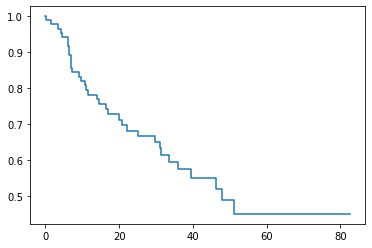

In [15]:
plt.step(x=df_survival['time'], y=df_survival['survival_prob'], where='post')
display()

#### Kaplan-Meier Survival Curve using Lifelines KaplanMeierFitter

We can check the correctness of the manual calculation using the lifelines library. 

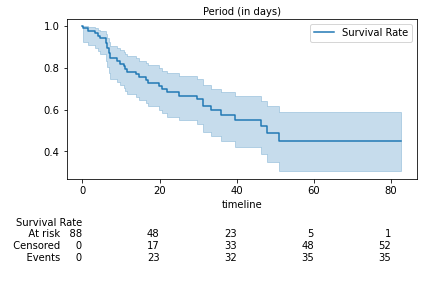

In [18]:
kmf = KaplanMeierFitter()
kmf.fit(df["time"], df["status"], label='Survival Rate')
kmf.plot(at_risk_counts=True)
plt.xlabel('Period (in days)')
plt.ylabel('Survival rate')
display()

The 2 survival curves are actually identical:

In [21]:
assert all(np.isclose(df_survival['survival_prob'].values, kmf.survival_function_['Survival Rate'].values))

True